In [1]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

numtaps = 16
coefficients = signal.firwin(numtaps, np.array(3), pass_zero='lowpass', fs = 400)

xs = np.linspace(0, 1, 400)

def sinusoidal_wave(xs, f):
    return np.sin(2 * np.pi * f * xs)

input_signal = np.array((5 * sinusoidal_wave(xs, 1) + 
                         3 * sinusoidal_wave(xs, 50) + 
                         3 * sinusoidal_wave(xs, 180))*1e3).astype(int)

In [2]:
vhdl_coeff = (coefficients*1e3).astype(int)

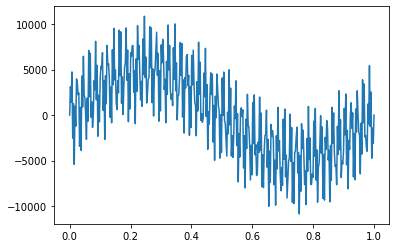

In [3]:
plt.plot(xs, input_signal)
plt.show()

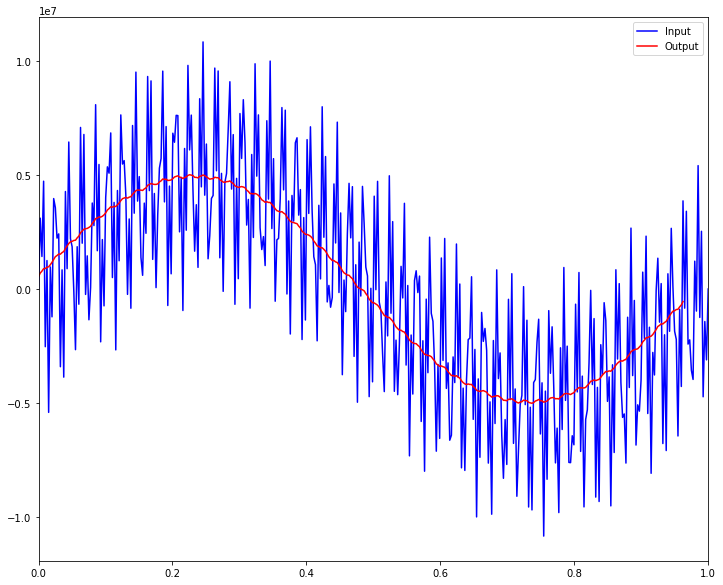

In [5]:
filtered_signal = np.convolve(input_signal, vhdl_coeff, mode='valid')
plt.figure(figsize=(12,10))
plt.plot(xs, input_signal*1e3, c='b', label='Input')
plt.plot(xs[0:len(filtered_signal)], filtered_signal, c='r', label='Output')
plt.xlim(0, 1)
plt.legend()
plt.show()

In [ ]:
f = "input_vectors.txt"
file_i = np.savetxt(f, input_signal)
c = "fir_taps.txt"
file_c = np.savetxt(c, coefficients)
o = "output_verify.txt"
file_o = np.savetxt(o, filtered_signal, fmt = '%i')

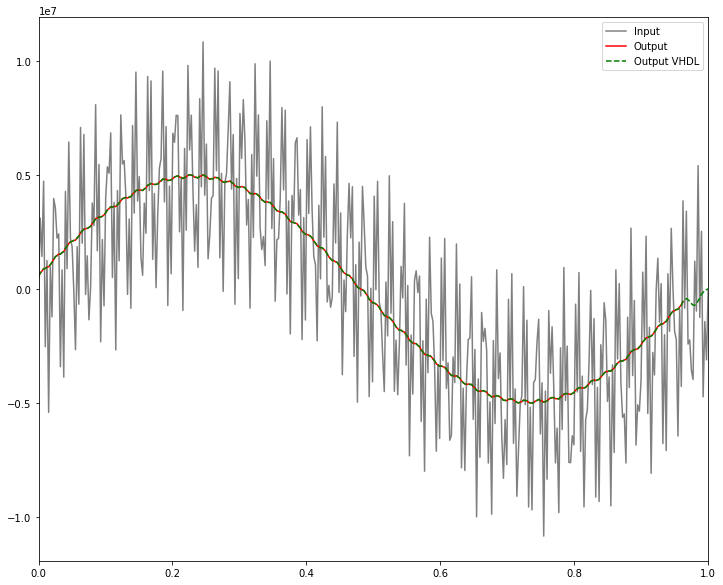

In [8]:
o_vhd = np.loadtxt("output_results.txt")
plt.figure(figsize=(12,10))
plt.plot(xs, input_signal*1e3, c='gray', label='Input')
plt.plot(xs[0:len(filtered_signal)], filtered_signal, c='r', label='Output')
plt.plot(xs, o_vhd[0:len(xs)],'--' ,c='green', label='Output VHDL')
plt.xlim(0, 1)
plt.legend()
plt.show()